## Defining our verifier

In [22]:
# Here, we are going with a Programmatic Verification approach since this makes most sense for the use case!
def meets_word_count(s: str, max_words: int, tolerance: float = 0.85) -> tuple[bool, int]:
    """
    Returns whether or not the string `s` meets the word count requirement, with a given tolerance.

    It also returns the delta from the max word count.

    Args:
        s (str): The input string to check.
        max_words (int): The maximum allowed word count.
        tolerance (float): The tolerance level (between 0 and 1) for the word count. Defaults to 0.85.
    """
    words = s.split()
    return len(words) <= max_words and len(words) >= int(max_words * tolerance), max_words - len(words)

# Always test your code!
print(meets_word_count("This is a test string.", 5)) # True, 0
print(meets_word_count("This is a test string.", 4)) # False, -1
print(meets_word_count("This", 5)) # False, 4

(True, 0)
(False, -1)
(False, 4)


## The Resume

In [5]:
with open("data/toy_problem_1/job_resume.txt", "r") as f:
    resume = f.read()

print(resume)

John Doe
Email: johndoe@uwaterloo.ca | Phone: (555) 123-4567 | GitHub: github.com/johndoe | LinkedIn: linkedin.com/in/johndoe
Education: Candidate for BCS, Honours Computer Science, University of Waterloo (Class of 2026)
GPA: 3.7/4.0

---

Technical Skills
- Languages: Python, Java, C++, JavaScript/TypeScript, SQL
- Frameworks & Tools: React, Node.js, Express, Flask, Docker, Git, Linux, AWS (EC2, S3)
- Interests: Full-stack development, distributed systems, cloud infrastructure, and AI/ML applications

---

Work Experience

Software Engineering Intern – Shopify, Ottawa, ON
May 2024 – August 2024
- Contributed to the checkout optimization team, improving load times by ~18% by rewriting key backend endpoints in Go.
- Implemented monitoring dashboards using Grafana + Prometheus, allowing the team to detect and respond to incidents 30% faster.
- Collaborated with product managers and designers to ship A/B tested features that increased conversion rates for merchants.

Backend Developer Co-

## The Job Application

In [4]:
# Load in the questions
import json

with open("data/toy_problem_1/job_application_questions.jsonl", "r") as f:
    questions = [json.loads(line) for line in f.readlines()]

for idx, question in enumerate(questions):
    print(f"{idx + 1}) {question['question']} Max word count: {question['max_word_count']}")

1) Why are you interested in working at our company, and how does our mission align with your career goals? Max word count: 300
2) Describe a technical project you’ve worked on that you are most proud of. What was your role and what impact did it have? Max word count: 250
3) Tell us about a time you faced a significant coding or technical challenge. How did you approach solving it? Max word count: 500
4) How do you stay up-to-date with the latest tools, frameworks, and technologies in software engineering? Max word count: 150
5) Explain a situation where you had to collaborate with teammates (engineers, designers, or PMs) to deliver a project. What did you learn from the experience? Max word count: 1000


## Build the Prompts

In [23]:
def build_prompt(resume: str, question: str, max_word_count: int) -> str:

    prompt = f"""You are an expert job application writer. You have been given the following resume:
<resume>
{resume}
</resume>

Please answer the following question based on the resume provided. 

Your answer must be no more than **{max_word_count}** words, but the length should also not fall too far below this limit (at least 85% of the max word count).

Question: {question}

Please provide JUST the response to the question without any additional commentary.

Response:"""

    return prompt

# Always test your code!
print(build_prompt("TEST RESUME", "Hello how are you?", 5))

You are an expert job application writer. You have been given the following resume:
<resume>
TEST RESUME
</resume>

Please answer the following question based on the resume provided. 

Your answer must be no more than **5** words, but the length should also not fall too far below this limit (at least 85% of the max word count).

Question: Hello how are you?

Please provide JUST the response to the question without any additional commentary.

Response:


## Baseline

We generate 1 response for each question. Let's see how many pass the application.

In [ ]:
from utils.model_utils import chat_n_times
import copy 

def run_generation(
        resume: str, 
        questions: list[dict], 
        num_responses, 
        model: str = "command-a-03-2025", 
        temp: float = 1.0, 
        p: float = 1.0) -> None:

    # For every question
    for question in questions:

        question["responses"] = []
        question["correct_responses"] = []
        question["best_response"] = None

        # build the prompt
        prompt = build_prompt(resume, question["question"], question["max_word_count"])
        
        # always store your prompt for easy debugging!
        question["prompt"] = prompt

        # sample from the model num_responses times
        outputs = chat_n_times(
            n=num_responses,
            model=model,
            messages=[{"role": "user", "content": prompt}],
            temperature=temp,
            p=p
        )

        for o in outputs:
            if o["ok"]:
                response = o['response'].message.content[-1].text

                # Store the response
                question["responses"].append(response)

                # Determine whether or not response was "correct"
                is_correct, wc_delta = meets_word_count(response, question["max_word_count"]) 
                if is_correct:
                    question["correct_responses"].append((response, wc_delta))

            else:
                print(f"FAILED TO GET RESPONSE: {o['error']}")


        question["passes"] = len(question["correct_responses"]) > 0
        if question["passes"]:
            question["best_response"] = sorted(question["correct_responses"], key=lambda x: x[1], reverse=False)[0]


baseline_questions = copy.deepcopy(questions)
run_generation(resume, baseline_questions, 1)

In [52]:
pass_rate = len([q for q in baseline_questions if q["passes"]]) / len(baseline_questions)
pass_rate

0.0

## Test-Time Scaling Approach

In [62]:
stats = []

# Let's scale num_trials by powers of two
for i in range(0, 7):

    num_trials = 2 ** i
    ttc_questions = copy.deepcopy(questions)
    run_generation(resume, ttc_questions, num_trials)

    pass_rate = len([q for q in ttc_questions if q["passes"]]) / len(ttc_questions)
    stats.append((num_trials, pass_rate))

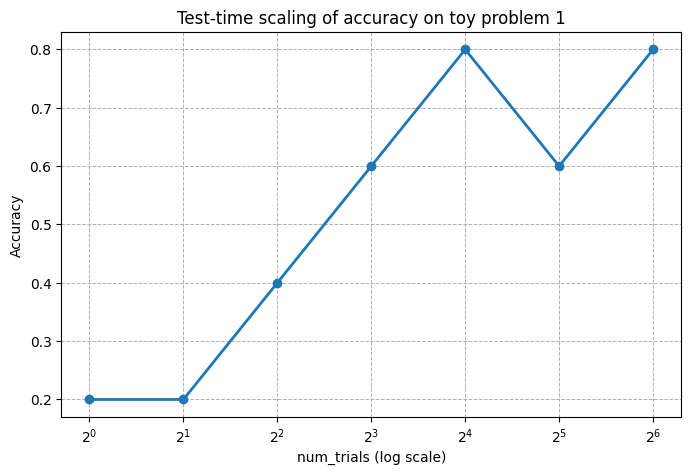

In [65]:
import matplotlib.pyplot as plt

def plot_log_line(data):
    """
    Plots a line graph with x-axis on log scale.
    
    Parameters:
        data (list of tuples): Each tuple contains (x, y), 
                               where x is a power of 2 and y is between 0 and 1.
    """
    # Unpack the tuples into x and y lists
    x, y = zip(*data)

    plt.figure(figsize=(8, 5))
    plt.plot(x, y, marker="o", linestyle="-", linewidth=2)

    # Set log scale for x-axis
    plt.xscale("log", base=2)

    # Labels and title
    plt.xlabel("num_trials (log scale)")
    plt.ylabel("Accuracy")
    plt.title("Test-time scaling of accuracy on toy problem 1")
    plt.grid(True, which="both", linestyle="--", linewidth=0.7)
    plt.show()

plot_log_line(stats)

We see that the accuracy starts to plateau around 2^4 = 16 generations per prompt with around 80% accuracy. So anything higher doesn't appear to yield more gains as it starts to oscillate. This is obviously sample size = 1 so this isn't rigorous by any means, but it does give us some signal as to what our ideal num_trials could be!